<a href="https://colab.research.google.com/github/xcarslan/cerenonetelent23/blob/main/VGG16_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Veri yolları
train_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Train'
validation_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Validation'
test_data_dir = '/content/drive/MyDrive/Proje Tasarımı/Split/Test'

# Veri artırma işlemleri
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8,1.2],
    channel_shift_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Veri setlerini yükleme
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# VGG16 modeli
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # Önceden eğitilmiş katmanların ağırlıklarını dondur

# Özelleştirilmiş katmanlar
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 sınıf için softmax aktivasyon

model = Model(inputs=base_model.input, outputs=predictions)

# Modelin derlenmesi
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

# Callback'ler
checkpoint = ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Model eğitimi
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, lr_schedule])

# En iyi modeli kaydetme
model.save('vgg16_final_model.h5')

# Test veri seti ile değerlendirme
test_generator = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test AUC: {test_auc}, Test Precision: {test_precision}, Test Recall: {test_recall}")


Found 3600 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 1.0032 - accuracy: 0.5211 - auc: 0.8125 - precision: 0.5660 - recall: 0.3731
Epoch 1: val_accuracy improved from -inf to 0.68167, saving model to vgg16_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - 1399s 12s/step - loss: 1.0032 - accuracy: 0.5211 - auc: 0.8125 - precision: 0.5660 - recall: 0.3731 - val_loss: 0.6590 - val_accuracy: 0.6817 - val_auc: 0.9165 - val_precision: 0.6980 - val_recall: 0.5758 - lr: 1.0000e-04
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.7881 - accuracy: 0.5889 - auc: 0.8722 - precision: 0.6189 - recall: 0.4939
Epoch 2: val_accuracy did not improve from 0.68167
113/113 [==============================] - 52s 460ms/step - loss: 0.7881 - accuracy: 0.5889 - auc: 0.8722 - precision: 0.6189 - recall: 0.4939 - val_loss: 0.6202 - val_accuracy: 0.6600 - val_auc: 0.9162 - val_precision: 0.6678 - val_recall: 0.6317 - lr: 1.0000e-04
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.6167 - auc: 0.8830 - precision: 0.6361 - recall: 0.5447
Epoch 3: val_accuracy improved from 0.68167 to 0.69500, saving model to vgg16_best_model.h5
113/113 [========================

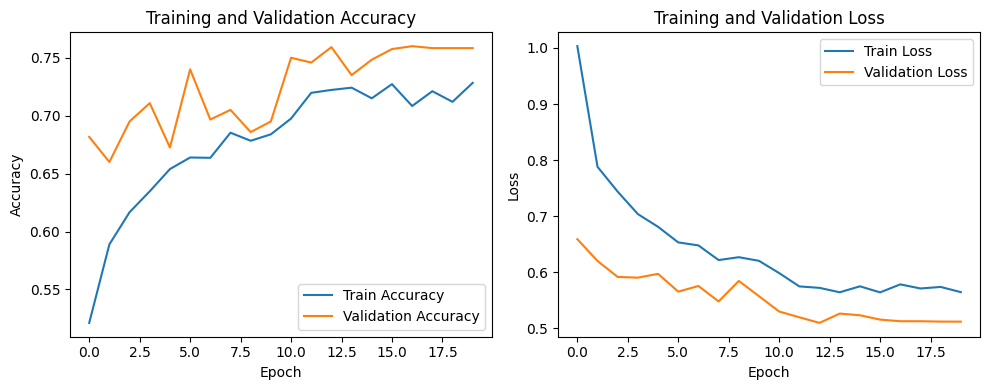

In [4]:
import matplotlib.pyplot as plt

# Eğitim ve Doğrulama Doğruluğunu Çizme
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve Doğrulama Kaybını Çizme
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
